In [1]:
import pandas as pd
from xbbg import blp
import matplotlib.pyplot as plt

#import string

# Parameters

In [2]:
SAVE_DATA = True

STARTDATE = '2008-01-01'
ENDDATE = '2025-01-14'

### Helper Function

In [3]:
def next_business_day(DATE):
    
    ONE_DAY = datetime.timedelta(days=1)
    HOLIDAYS_US = holidays.US()

    next_day = DATE
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day

# Exchange Rates

In [4]:
ticks = ['USDUSD Curncy','JPYUSD Curncy','EURUSD Curncy','GBPUSD Curncy','MXNUSD Curncy', 'CHFUSD Curncy']

In [5]:
rawdata = blp.bdh(tickers=ticks, flds='last_price',\
        start_date=STARTDATE, end_date=ENDDATE).droplevel(level=1,axis=1)

rawdata.index = pd.to_datetime(rawdata.index)

In [6]:
newcols = [col[:3] for col in rawdata.columns]
fxdata = rawdata.copy()
fxdata.columns = newcols

fxdata.index.name = 'date'

In [7]:
fxdata

,JPY,EUR,GBP,MXN,CHF
date,,,,,
2008-01-01,0.008957,1.4592,1.9864,0.09183,0.8824
2008-01-02,0.009119,1.4715,1.9808,0.09162,0.8933
2008-01-03,0.009148,1.4750,1.9710,0.09187,0.9002
2008-01-04,0.009209,1.4743,1.9740,0.09154,0.9022
2008-01-07,0.009159,1.4696,1.9704,0.09176,0.8957
...,...,...,...,...,...
2025-01-08,0.006315,1.0318,1.2363,0.04902,1.0976
2025-01-09,0.006324,1.0300,1.2308,0.04875,1.0964
2025-01-10,0.006340,1.0244,1.2207,0.04827,1.0913


***

# Risk-free Rates

In [8]:
ticks = ['SOFRRATE Index','MUTKCALM Index','ESTRON Index','SONIO/N Index','MXONBR Index', 'SZLTDEP Index']

In [9]:
ratedata = blp.bdh(tickers=ticks, flds='last_price',\
        start_date=STARTDATE, end_date=ENDDATE).droplevel(level=1,axis=1)

ratedata.index = pd.to_datetime(ratedata.index)

rateindex = ratedata.copy()

In [10]:
ticks = ['USDR1T CMPN Curncy','JYDR1T CMPN Curncy','EUDR1T CMPN Curncy','BPDR1T CMPN Curncy','MPDR1T CMPN Curncy', 'SFDR1T CMPN Curncy']

ratedata = blp.bdh(tickers=ticks, flds='last_price',\
        start_date=STARTDATE, end_date=ENDDATE).droplevel(level=1,axis=1)

ratedata.index = pd.to_datetime(ratedata.index)

ratedeposits = ratedata.copy()

### Combine Data Sets

Index and Deposit measures of RF

In [11]:
allratedata = pd.concat([rateindex,ratedeposits],axis=1)

In [12]:
codes = dict({
    'USD':['SOFRRATE Index', 'USDR1T CMPN Curncy'],
    'JPY':['MUTKCALM Index','JYDR1T CMPN Curncy'],
    'EUR':['ESTRON Index','EUDR1T CMPN Curncy'],
    'GBP':['SONIO/N Index','BPDR1T CMPN Curncy'],
    'MXN':['MXONBR Index','MPDR1T CMPN Curncy'],
    'CHF':['SZLTDEP Index','SFDR1T CMPN Curncy']
})

### Determine whether to use Deposit or Index Measure

Mixing across them, so not completely comparable

In [13]:
USEINDEX = None

if USEINDEX is None:
    list_index = ['JPY','MXN']
elif USEINDEX:
    list_index = list(codes.keys())
else:
    list_index = []

In [14]:
cols = []
for c in codes.keys():
    if c in list_index:
        idx = 0        
    else:
        idx = 1
        
    cols.append(codes[c][idx])

In [15]:
rfdata = allratedata[cols]

rename_dict = {key: value for key, value in zip(cols, codes.keys())}
rfdata = rfdata.rename(columns=rename_dict)
rfdata /= 100

rfdata.index.name = 'date'

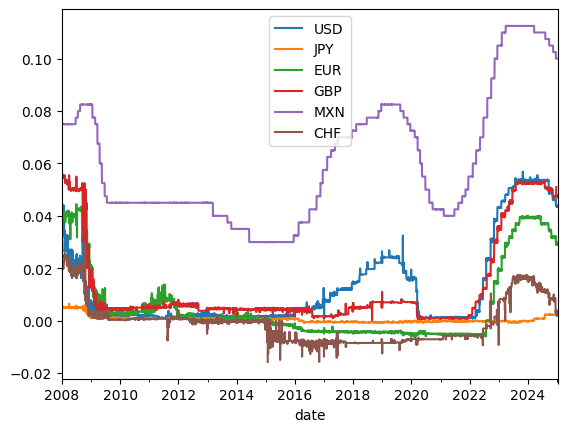

In [16]:
rfdata.plot();

# Process Risk-free rate data

In [17]:
rfdata.ffill(inplace=True)
rfdata.bfill(inplace=True)


# Get Info

In [18]:
# info = pd.DataFrame(map_tick_des)
# info.columns = ['maturity','BB ticker']
# info = info.set_index('maturity').sort_index()

***

# Save Data

In [19]:
if SAVE_DATA:
    outfile = f'../data/fx_rf_data_{ENDDATE}.xlsx'
    with pd.ExcelWriter(outfile) as writer:  
        #info.to_excel(writer, sheet_name= 'info', index=True)
        rfdata.to_excel(writer, sheet_name= 'risk-free rates', index=True)
        fxdata.to_excel(writer, sheet_name= 'exchange rates', index=True)

***

# Compare Index vs Deposit for Each Currency

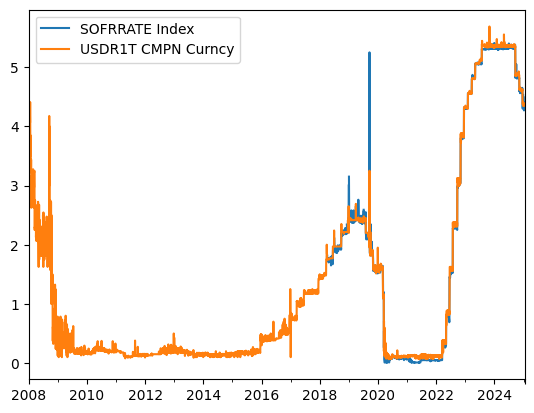

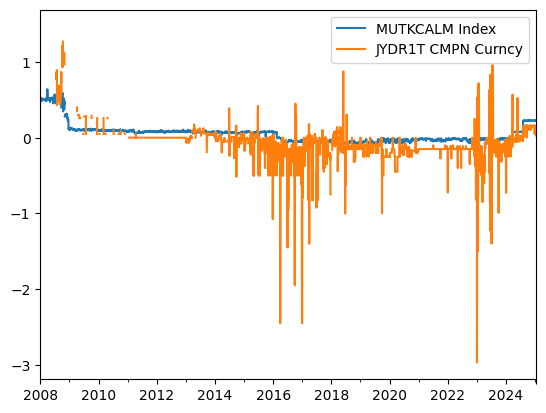

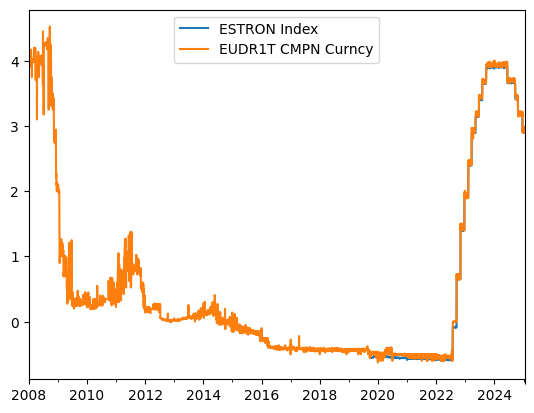

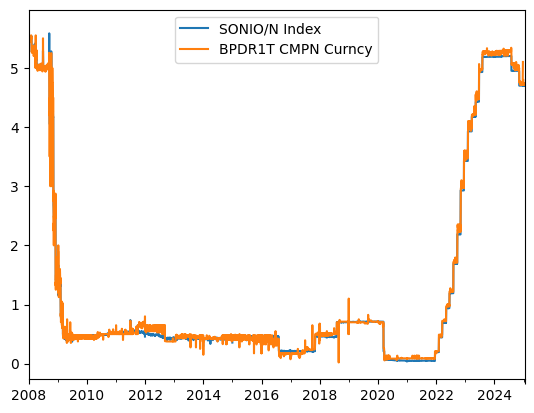

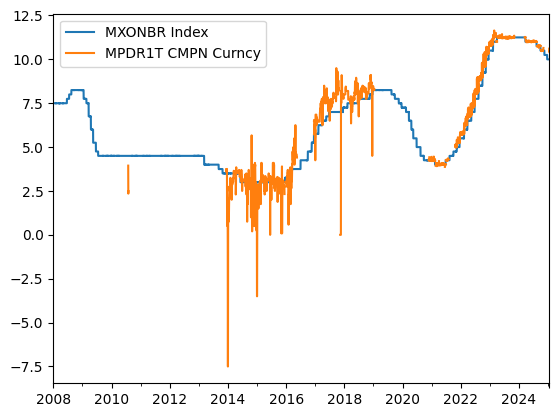

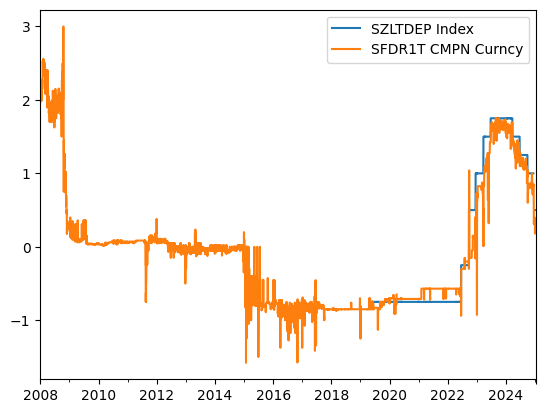

In [20]:
for val in codes.values():
    allratedata[val].plot()